In [3]:
### library
import os
import pandas as pd
import pylab as pl
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
import tensorflow as tf
# from PIL import Image
from scipy import ndimage

import math
from lr_utils import load_dataset
import sklearn
import sklearn.datasets
import sklearn.linear_model

%matplotlib inline

import opt_utils_v1a
from opt_utils_v1a import *
from testCases import *

import gc_utils
from gc_utils import *    
import testCases_v2
import planar_utils
from testCases_v2 import *
from planar_utils import *

import reg_utils
from reg_utils import *
import testCases
from testCases import *

import testCases
from testCases import *
import init_utils
from init_utils import *
import lr_utils
from lr_utils import *
import testCases_v4a
from testCases_v4a import *
import dnn_utils_v2
from dnn_utils_v2 import *
from testCases_v4a import *
from dnn_utils_v2 import sigmoid, sigmoid_backward, relu, relu_backward
import dnn_app_utils_v3
from dnn_app_utils_v3 import *

plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1) # set a seed 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


y = [0], it's a 'non-cat' picture.


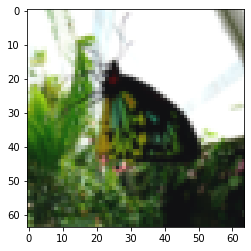

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)
train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


In [20]:
### Logistic Regression modeling

## load dataset
# - udf
def load_dataset():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) #  train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) #  train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) #  test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) #  test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()
train_set_x_orig.shape

# Example of a picture
index = 30
plt.imshow(train_set_x_orig[16])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")
plt.show()
# dimensions and shapes of the problem 
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

## train/test set
train_set_x_flatten = train_set_x_orig.reshape(
    train_set_x_orig.shape[0],
    (train_set_x_orig.shape[1]*train_set_x_orig.shape[2]*train_set_x_orig.shape[3])
    ).T

test_set_x_flatten = test_set_x_orig.reshape(
    test_set_x_orig.shape[0],
    (test_set_x_orig.shape[1]*test_set_x_orig.shape[2]*test_set_x_orig.shape[3])
    ).T
print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

# standardize the data
train_set_x = train_set_x_flatten/255.0
test_set_x = test_set_x_flatten/255.0

In [21]:
## modeling prep

# helper function

def sigmoid(z):
    s = 1 / (1 + np.exp(-z))
    return s

# initialize parameters
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.    
    Argument:dim --> size of the w vector we want (or number of parameters in this case)
    Returns: w --> initialized vector of shape (dim, 1)
             b --> initialized scalar (corresponds to the bias)
    """
    
    w = np.zeros((dim,1));  b = 0
    
    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

# forward and backward propagation
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    L_cost -- negative log-likelihood cost for logistic regression
    dL_dw -- gradient of the loss with respect to w, thus same shape as w
    dL_db -- gradient of the loss with respect to b, thus same shape as b
    """
    
    m = X.shape[1]
    
    ## FORWARD PROPAGATION (FROM X TO COST)    
    A = sigmoid( np.dot(w.T,X) + b )                          # compute activation    
    L_cost = -1/m * np.sum(  ( Y*np.log(A) + (1-Y)*np.log(1-A) )  )    # compute cost    
    
    # BACKWARD PROPAGATION (to find gradient)
    dL_dW = 1/m * (np.dot( X, (A-Y).T ))
    dL_dB = 1/m * np.sum(A - Y)
    
    cost = L_cost; dw = dL_dW; db = dL_dB

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function - dL/dw, dL/db
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
        
    params, grads, costs = optimize(w, b, X, Y, num_iterations, learning_rate, print_cost=False)    
    """
    
    costs = []
    
    for i in range(num_iterations):        
        
        ## Cost and gradient calculation (≈ 1-4 lines of code) 
        grads, cost = propagate(w, b, X, Y)
        # Retrieve derivatives from grads
        dL_dw = grads["dw"]
        dL_db = grads["db"]
        
        # update rule (≈ 2 lines of code)       
        w = w - learning_rate * dL_dw
        b = b - learning_rate * dL_db
        
        # Record the every 100th costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if (print_cost and i % 100 == 0):
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    dw = dL_dw; db = dL_db    
    grads = {"dw": dw,
             "db": db}
    
    return (params, grads, costs)


def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    A = sigmoid( np.dot(w.T,X) + b  )

    Y_prediction[np.where(A >= 0.5)] = 1
    Y_prediction[np.where(A <  0.5)] = 0 
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [22]:
# merge all functions inside a model function
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initialize_with_zeros(dim = X_train.shape[0])

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w, b, X_train, Y_train,
                                        num_iterations, learning_rate, print_cost)    
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w,b, X=  X_test)
    Y_prediction_train = predict(w,b, X = X_train)


    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [23]:
# run the model
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


y = 0, you predicted that it is a "cat" picture.


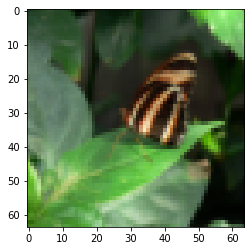

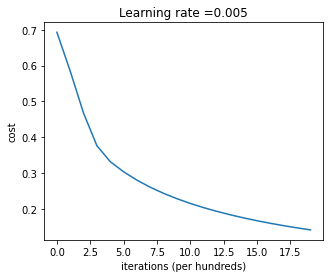

Learning rate is...0.01
train accuracy: 99.52153110047847 %
test accuracy: 68.0 %

-------------------------------------------------------

Learning rate is...0.001
train accuracy: 88.99521531100478 %
test accuracy: 64.0 %

-------------------------------------------------------

Learning rate is...0.0001
train accuracy: 68.42105263157895 %
test accuracy: 36.0 %

-------------------------------------------------------



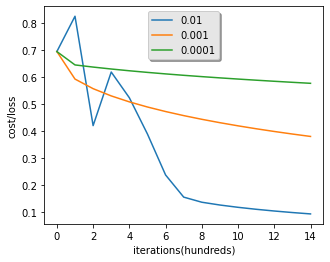

In [32]:
# Example of a picture that was wrongly classified.
index = 5
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + \
       classes[int(d["Y_prediction_test"][0,index])].decode("utf-8") +  "\" picture.")
plt.show()

# Plot: Cost @ every iteration
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

# chossing different choice
# learning rate
alphas = [0.01, 0.001, 0.0001]

models = {}

for each_alpha in alphas:
    print("Learning rate is..." + str(each_alpha))
    models[str(each_alpha)] = model(train_set_x, train_set_y, test_set_x, test_set_y,
                                   num_iterations= 1500, learning_rate= each_alpha, print_cost= False)
    
    print ('\n' + "-------------------------------------------------------" + '\n')
    
for each_alpha in alphas:
    plt.plot(np.squeeze(models[str(each_alpha)]['costs']),
            label = str(models[str(each_alpha)]['learning_rate'])
            )
plt.ylabel('cost/loss')
plt.xlabel('iterations(hundreds)')

legend = plt.legend(loc = 'upper center', shadow= True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()